In [1]:
pip_list = !pip list
packages = ["chardet", "dabl", "imblearn", "keras-tuner", "mysql-connector-python", "numpy", "pandas", "sklearn", "statsmodels", "tensorflow"]
for package in packages:
    if not pip_list.grep(package):
        !pip3 install {package}

print("Package installations completed.")

Package installations completed.


In [2]:
import calendar
import datetime
import os
import shutil
import warnings
from pickle import dump

import chardet
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
import requests
import scipy.stats as stat
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
from dabl import SimpleClassifier, SimpleRegressor, clean, plot
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from IPython.display import display
from keras_tuner.tuners import BayesianOptimization, Hyperband, RandomSearch
from mysql.connector import errorcode
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.datasets import (load_breast_cancer, load_diabetes, load_iris,
                              load_wine)
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import (SelectPercentile, VarianceThreshold,
                                       chi2, f_classif)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.model_selection import (RandomizedSearchCV, StratifiedKFold,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (MinMaxScaler, OneHotEncoder, OrdinalEncoder,
                                   StandardScaler)
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
set_config(display="diagram", print_changed_only=False)
pd.set_option("display.float_format", lambda f: "%.2f" % f)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.rc("axes", labelsize=12)
plt.rc("axes", titlesize=12)
plt.rc("font", size=10)
plt.rcParams["figure.figsize"] = [18, 7]
plt.style.use("dark_background")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())
print(os.system("cat /proc/cpuinfo | grep 'model name'"))
print(os.system("cat /proc/meminfo | grep 'MemTotal'"))
print(os.system("nvidia-smi"))

2022-06-03 23:31:44.493063: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-03 23:31:44.493119: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11511550954239328200
xla_global_id: -1
]
[]

model name	: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz
model name	: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz
model name	: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz
model name	: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz
model name	: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz
model name	: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz
model name	: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz
model name	: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz
0
MemTotal:       16228132 kB
0
32512


/workspaces/PersonalExpense/.venv/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
2022-06-03 23:31:46.630576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-03 23:31:46.631691: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-03 23:31:46.631705: W tensorflow/stream_executor/cuda/cuda_driv

In [3]:
df = pd.read_csv("../data/transaction.csv", delimiter=",", thousands=",")
display(df)

,BSB Number,Account Number,Transaction Date,Narration,Cheque Number,Debit,Credit,Balance,Transaction Type
0,303-537,172418,31/05/2022,CATHERINE LIM korean salary,NaN,NaN,700.00,118260.67,DEP
1,303-537,172418,31/05/2022,BEST AND LESS CHELTENHAM AUS,NaN,-24.00,NaN,117560.67,WDC
2,303-537,172418,30/05/2022,COLES 0508 GLEN WAVERLEY AUS,NaN,-32.53,NaN,117584.67,WDC
3,303-537,172418,30/05/2022,GREATER WESTERN WA SUNBURY AUS,NaN,-31.91,NaN,117617.20,WDC
4,303-537,172418,27/05/2022,ORIGIN ELEC 051500610095,NaN,-58.27,NaN,117649.11,WDL
...,...,...,...,...,...,...,...,...,...
276,303-537,172418,02/02/2022,PERIODICAL PAYMENT TO COMPLETE VARIABLE HL,NaN,-240.27,NaN,102624.29,WDL
277,303-537,172418,01/02/2022,HI-TOUCH TECHNOLOGY PT CHELTENHAM 00,NaN,-99.00,NaN,102864.56,WDL
278,303-537,172418,01/02/2022,PSW 1000 CHELTENHAM 00,NaN,-86.95,NaN,102963.56,WDL
279,303-537,172418,01/02/2022,BIG W 0375.CHELTENHAM VIC 00,NaN,-39.00,NaN,103050.51,WDL


In [4]:
RANDOM_STATE = 11
SEARCH = ["hyperband", "random", "bayesian"][0]
EPOCHS = 500
MAX_TRIALS = 20
DUPLICATES = 0
SCALER = 1
CLASSIFICATION = 0

print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Duplicates Percentage: {df.duplicated().sum() / df.shape[0] * 100:.2f}%")
if DUPLICATES:
    print(f"Duplicates have been kept {df.shape}.")
else:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates have been removed {df.shape}.")
display(df.sample(3))
y_label = "Balance"

-------------------------------------------------------
Current Shape: (281, 9).
-------------------------------------------------------
Duplicates Percentage: 0.00%
Duplicates have been removed (281, 9).


,BSB Number,Account Number,Transaction Date,Narration,Cheque Number,Debit,Credit,Balance,Transaction Type
225,303-537,172418,28/02/2022,Babyeggs Moorabbin 00,NaN,-27.00,NaN,104250.60,WDL
168,303-537,172418,23/03/2022,PERIODICAL PAYMENT TO COMPLETE VARIABLE HL,NaN,-240.27,NaN,105677.82,WDL
223,303-537,172418,01/03/2022,BEST AND LESS CHELTENHAM 00,NaN,-38.00,NaN,104180.60,WDL


In [5]:
df.dropna(subset=[y_label], inplace=True)
print("-------------------------------------------------------")
print(f"Dropping null target values.")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
# df[y_label] = df[y_label].map({k: i for i, k in enumerate(np.sort(df[y_label].unique()), 0)})
print(f"y Value Counts:\n{df[y_label].value_counts()}")

-------------------------------------------------------
Dropping null target values.
Current Shape: (281, 9).
-------------------------------------------------------
y Value Counts:
111834.31    2
109785.44    2
101821.54    2
118260.67    1
106341.86    1
            ..
111807.53    1
112047.80    1
112147.30    1
112186.63    1
103089.51    1
Name: Balance, Length: 278, dtype: int64


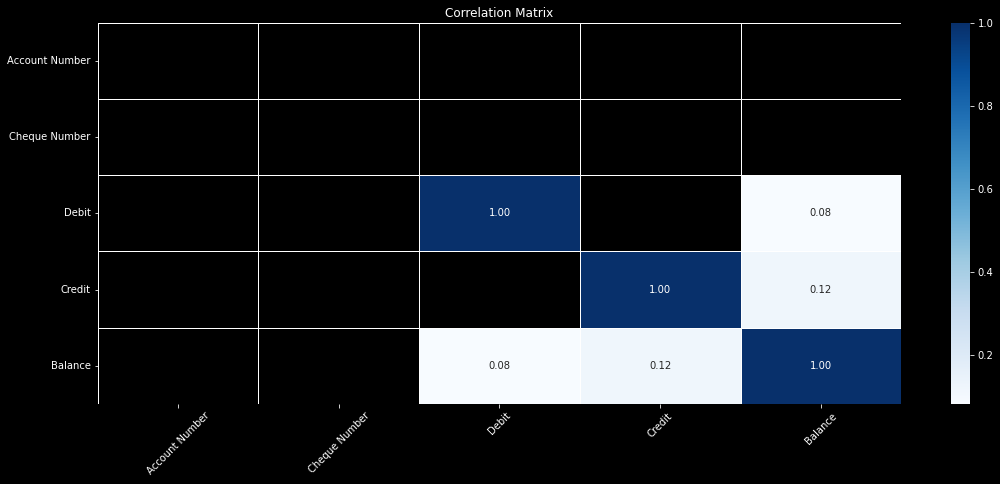

In [6]:
sns.heatmap(df.corr(), cmap="Blues", fmt=".2f", annot=True, linewidths=1)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.show()

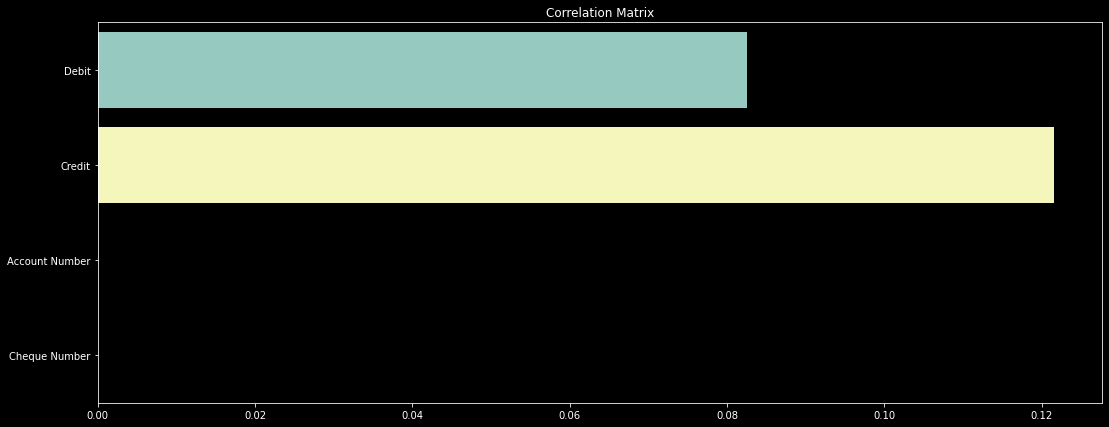

In [7]:
corr_matrix = df.corr()[y_label].sort_values().drop(y_label)
sns.barplot(x=corr_matrix.values, y=corr_matrix.index).set_title("Correlation Matrix")
plt.show()

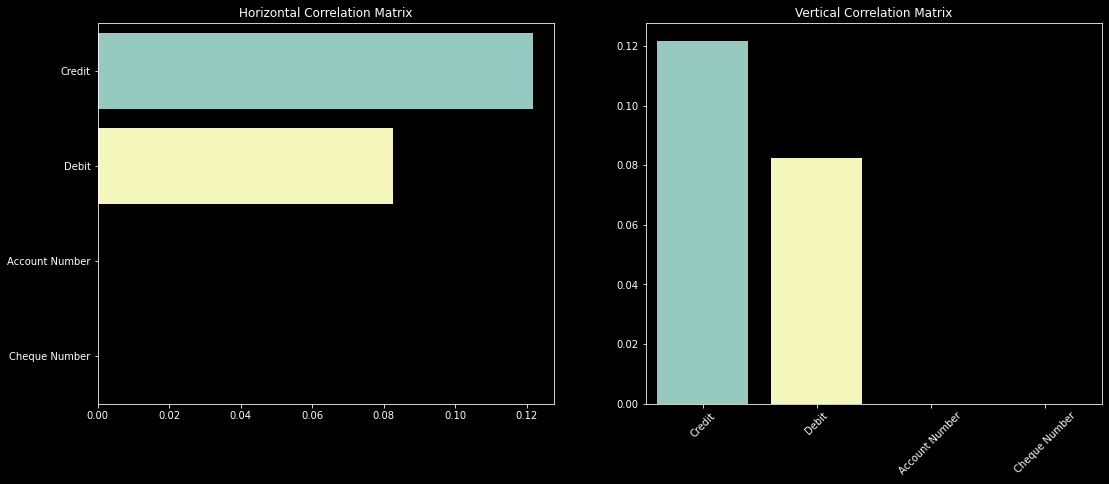

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2)
corr_matrix = df.corr()[y_label].abs().sort_values(ascending=False).drop(y_label)
sns.barplot(x=corr_matrix.values, y=corr_matrix.index, ax=ax[0]).set_title("Horizontal Correlation Matrix")
sns.barplot(x=corr_matrix.index, y=corr_matrix.values, ax=ax[1]).set_title("Vertical Correlation Matrix")
plt.xticks(rotation=45)
plt.show()

In [9]:
def correlation(X, threshold):
    col_corr = set()
    df_corr = X.corr().abs()
    for i, _ in enumerate(df_corr.columns):
        for j in range(i):
            if (df_corr.iloc[i, j] >= threshold) and (
                df_corr.columns[j] not in col_corr
            ):
                col_corr.add(df_corr.columns[i])
    return col_corr

col_drop = correlation(df.drop(y_label, axis=1), 0.85)
df.drop(col_drop, inplace=True, axis=1)
print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Highly correlated cols have been removed: {len(col_drop)}.")
print(f"Highly correlated cols: {col_drop}.")

-------------------------------------------------------
Current Shape: (281, 9).
-------------------------------------------------------
Highly correlated cols have been removed: 0.
Highly correlated cols: set().


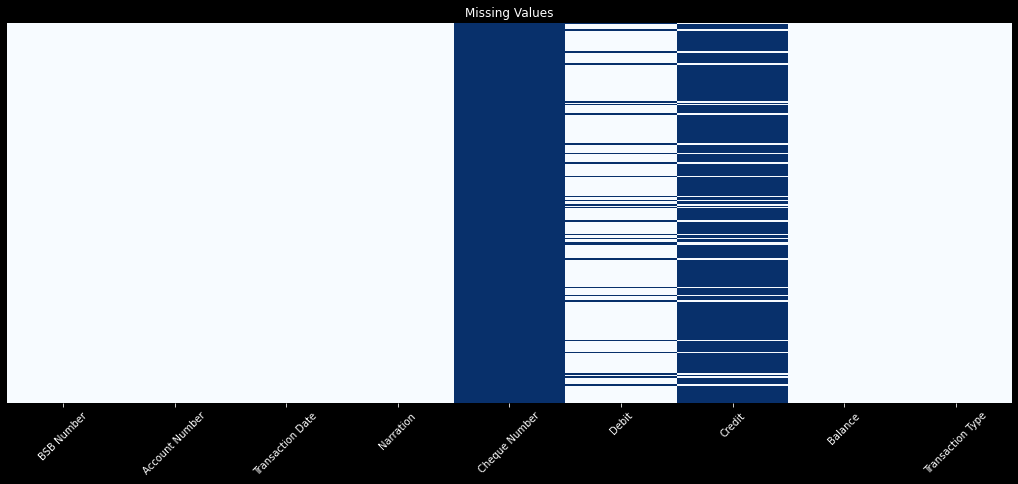

In [10]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="Blues")
plt.title("Missing Values")
plt.xticks(rotation=45)
plt.show()

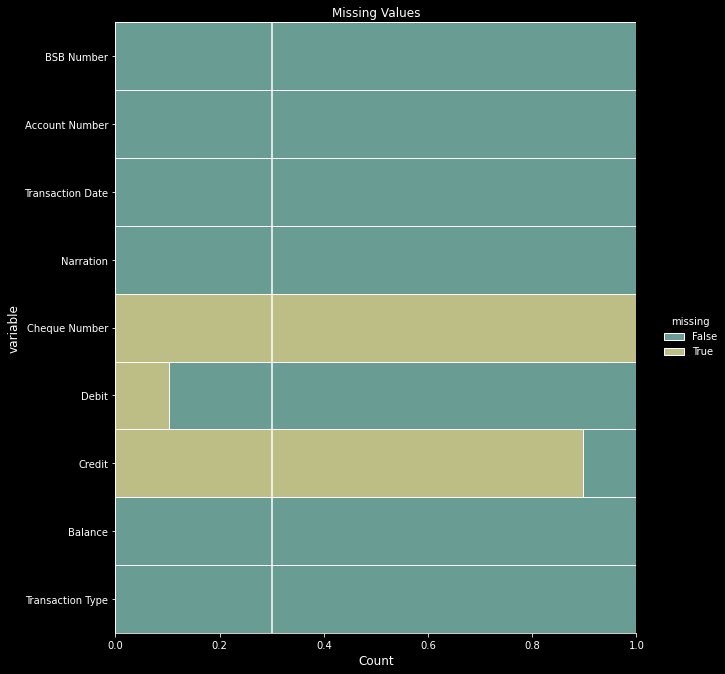

In [11]:
sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=9.25,
)
plt.axvline(0.3, color="white")
plt.title("Missing Values")
plt.show()

In [12]:
"""
%a: Weekday, abbreviated: Mon, Tues, Sat
%A: Weekday, full name: Monday, Tuesday, Saturday
%w: Weekday, decimal. 0=Sunday: 1, 2, 6
%d: Day of month, zero-padded: 01, 02, 21
%b: Month, abbreviated: Jan, Feb, Sep
%B: Month, full name: January, February, September
%m: Month number, zero-padded: 01, 02, 09
%y: Year, without century, zero-padded: 02, 95, 99
%Y: Year, with century: 1990, 2020
%H: Hour (24 hour), zero padded: 01, 22
%I: Hour (12 hour) zero padded: 01, 12
%p: AM or PM: AM, PM
%M: Minute, zero-padded: 01, 02, 43
%S: Second, zero padded: 01, 32, 59
%f: Microsecond, zero-padded: 000001, 000342, 999999
%z: UTC offset ±HHMM[SS[.ffffff]]: +0000, -1030, -3423.234
%Z: Time zone name: ITC, EST, CST
%j: Day of year, zero-padded: 001, 365, 023
%U: Week # of year, zero-padded. Sunday first day of week: 00, 01, 51
%W: Week # of year, zero-padded. Monday first day of week: 00, 02, 51
%c: Appropriate date and time: Monday Feb 01 21:30:00 1990
%x: Appropriate Date: 02/01/90
%X: Appropriate Time: 21:22:00
"""
df["Transaction Date"] = pd.to_datetime(df["Transaction Date"], format="%d/%m/%Y")
df["Transaction Month"] = df["Transaction Date"].dt.month
df.replace({np.nan: 0}, inplace=True)
df.drop(["BSB Number", "Transaction Type", "Account Number", "Cheque Number", "Transaction Date"], inplace=True, axis=1)
df["Narration"] = df["Narration"].str.lower()
mapping_table = {
    "catherine lim": "income",
    "best and": "personal care",
    "coles": "groceries",
    "greater western": "rent water",
    "origin elec": "Power & gas",
    "ezi*sky pilates": "recreation",
    "periodical payment": "loan",
    "hong kong": "groceries",
    "romeo hair": "personal care",
    "woolworths 32": "groceries",
    "costco wholesale": "groceries",
    "nab nab": "groceries",
    "woolworths 3295.oakleigh": "groceries",
    "costco fuel": "transport",
    "hakata gensuke": "groceries",
    "woolworths 33": "groceries",
    "myki parliamnt": "transport",
    "origin gas": "Power & gas",
    "salary cenitex": "income",
    "foodworks east": "groceries",
    "good times": "groceries",
    "flexischools*acc t": "education",
    "ezi*hht supreme": "other",
    "vodafone t3,20d628,5": "telephone",
    "stsolarvic solvic": "Power & gas",
    "woolworths 3110.bentleigh": "groceries",
    "big w": "groceries",
    "smp*maison arnaud": "recreation",
    "smiggle pty": "education",
    "ok-mart.com.au carnegie": "groceries",
    "medibank private": "medical",
    "market europa": "groceries",
    "coles 0581": "groceries",
    "sq *the": "recreation",
    "post moorabbin": "other",
    "pets domain": "groceries",
    "target 5419": "personal care",
    "coles 0643": "groceries",
    "cw oakleigh": "groceries",
    "palgong tea": "recreation",
    "marbled meats": "groceries",
    "linkbake pty": "groceries",
    "country road": "personal care",
    "wok n": "recreation",
    "melton realty": "rental income",
    "mcdonalds app": "recreation",
    "best blooms": "recreation",
    "cellars bentleigh": "groceries",
    "fees included": "recreation",
    "ling nan": "personal care",
    "coles 0625": "groceries",
    "coles 0595": "groceries",
    "woolworths 39": "groceries",
    "public transport": "transport",
    "brighton toyota": "transport",
    "south east": "water",
    "liv*trentham iga": "groceries",
    "com*southmoorprima moorabbin": "education",
    "smp*carter lovett": "recreation",
    "bakers delight": "groceries",
    "dirito quality": "groceries",
    "kmart mulgrave": "personal care",
    "chemist warehouse": "medical",
    "to hyunah": "groceries",
    "whitehorse city": "recreation",
    "feast on": "recreation",
    "vodafone t3,207feb,14": "telephone",
    "nekotsuri melbourne": "recreation",
    "woolworths 31": "groceries",
    "toyworld northland": "personal care",
    "woolworths 3336.cheltenham": "groceries",
    "degani waverley": "recreation",
    "woolworths 3130.waverley": "groceries",
    "top mart": "groceries",
    "coles 0553": "groceries",
    "1932 cafe": "recreation",
    "llaollao one": "recreation",
    "wilson parking": "recreation",
    "woolworths 3161.moorabbin": "groceries",
    "coles express": "groceries",
    "best quality": "groceries",
    "mcdonalds glen": "recreation",
    "sq *marimekko": "personal care",
    "trybooking* southm": "education",
    "bargain land": "personal care",
    "to catherine": "education",
    "chesterville pharm": "medical",
    "wellbeing korean": "recreation",
    "coles 0669": "groceries",
    "kmart 1154": "groceries",
    "copp parking": "recreation",
    "riparide* riparide": "recreation",
    "uber *eats": "recreation",
    "luna park": "recreation",
    "cotton on": "personal care",
    "etx oakleigh": "groceries",
    "custodian kitchen": "recreation",
    "hungry jacks": "recreation",
    "sq *peddler": "groceries",
    "aldi stores": "groceries",
    "vodafone t3,2019b6,b": "telephone",
    "kingston food": "groceries",
    "bunnings 477000": "house repair",
    "grouponau sydney": "groceries",
    "babyeggs moorabbin": "personal care",
    "target online": "personal care",
    "aami brisbane": "insurance",
    "industrybeans chadstone": "personal care",
    "trybooking* pyo": "recreation",
    "merrymen cafe": "recreation",
    "uniqlo australia": "personal care",
    "bws liquor": "groceries",
    "deliveroo north": "recreation",
    "to youngshin": "groceries",
    "taste of": "recreation",
    "cba atm": "groceries",
    "target 5086": "personal care",
    "michaels fresh": "groceries",
    "kryal castle": "recreation",
    "chesterville news": "personal care",
    "arcobar heatherton": "recreation",
    "psw 1000": "groceries",
    "marketplace fresh": "groceries",
    "kmart 1026": "groceries",
    "2 sisterz": "personal care",
    "vodafone t3,1fbbd6,12": "telephone",
    "sora gmk": "groceries",
    "woolworths 3251.carnegie": "groceries",
    "ebay o*09-08253-44": "personal care",
    "ib payment": "groceries",
    "au79 chadstone": "groceries",
    "colonial fruit": "groceries",
    "david jones": "personal care",
    "sodagift rancho": "recreation",
    "sq *artisanal": "groceries",
    "woolworths 3371.keysborough": "groceries",
    "starbucks coffee": "recreation",
    "smp*elfresco cafe": "recreation",
    "hi-touch technology": "personal care",
    "coles 0508": "groceries"
}
df["Narration"] = df["Narration"].map(lambda n: mapping_table.get(" ".join(n.split()[:2])))
df["Narration"].value_counts()

groceries        102
recreation        40
loan              38
personal care     26
income            19
transport         17
Power & gas        8
medical            8
education          7
other              4
telephone          4
rental income      4
rent water         1
water              1
house repair       1
insurance          1
Name: Narration, dtype: int64

In [13]:
col_cat_oe = []
preprocessor_cat_oe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OrdinalEncoder(categories=[["", ""]])),
)
col_cat = [col for col in df.columns if np.issubsctype(df[col].dtype, np.object0) and col != y_label]
col_num = [col for col in df.columns if np.issubsctype(df[col].dtype, np.number) and col != y_label]
col_cat_ohe = [col for col in col_cat if col not in col_cat_oe]
col_num_disc = [col for col in col_num if df[col].nunique() < 25]
col_num_cont = [col for col in col_num if col not in col_num_disc]

df_info = pd.DataFrame(
    {
        "column": [col for col in df.columns],
        "dtype": [f"{df[col].dtype}" for col in df.columns],
        "na": [f"{df[col].isna().sum()}" for col in df.columns],
        "na %": [f"{round(df[col].isna().sum() / df[col].shape[0] * 100)}%" for col in df.columns],
        "outliers": [f"{((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()}" if col in col_num else "n/a" for col in df.columns],
        "outliers %": [f"{round((((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()) / df[col].shape[0] * 100)}%" if col in col_num else "n/a" for col in df.columns],
        "kurtosis": [f"{df[col].kurtosis(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "skewness": [f"{df[col].skew(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "corr": [f"{round(df[col].corr(other=df[y_label]) * 100)}%" if col in col_num else "n/a" for col in df.columns],
        "nunique": [f"{df[col].nunique()}" for col in df.columns],
        "unique": [sorted(df[col].unique()) if col in col_num else df[col].unique() for col in df.columns],
    }
).sort_values(by="dtype", ascending=False)
display(df_info)
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"total na %: {df.isnull().sum().sum() / np.product(df.shape) * 100:.2f}%")
print("-------------------------------------------------------")
print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
print("-------------------------------------------------------")
print(f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_num_disc) + len(col_num_cont)}")

,column,dtype,na,na %,outliers,outliers %,kurtosis,skewness,corr,nunique,unique
0,Narration,object,0,0%,n/a,n/a,n/a,n/a,n/a,16,"[income, personal care, groceries, rent water,..."
4,Transaction Month,int64,0,0%,0,0%,-1.28,-0.05,92%,4,"[2, 3, 4, 5]"
1,Debit,float64,0,0%,48,17%,53.37,-5.85,9%,193,"[-3000.0, -985.88, -854.23, -800.84, -774.14, ..."
2,Credit,float64,0,0%,26,9%,23.70,4.83,7%,20,"[0.0, 2.0, 11.1, 27.0, 49.0, 103.0, 200.0, 700..."
3,Balance,float64,0,0%,n/a,n/a,n/a,n/a,n/a,278,"[118260.67, 117560.67, 117584.67, 117617.2, 11..."


Current Shape: (281, 5).
-------------------------------------------------------
total na %: 0.00%
-------------------------------------------------------
col_cat_oe (0): []
col_cat_ohe (1): ['Narration']
col_num_disc (2): ['Credit', 'Transaction Month']
col_num_cont (1): ['Debit']
-------------------------------------------------------
total cols for preprocessor: 4


In [14]:
MAX_COLS = 100
for col in col_cat_ohe:
    indice = df[col].value_counts()[:MAX_COLS].index
    df_temp = df[col].map(lambda value: value if value in indice else "-")
    # df[col] = df_temp
    print(df_temp.value_counts())
    print(f"unique values: {df_temp.nunique()}")
    print("-------------------------------------------------------")
try:
    display(df.describe(exclude="number").T.style.background_gradient(cmap="Blues"))
except Exception:
    pass

groceries        102
recreation        40
loan              38
personal care     26
income            19
transport         17
Power & gas        8
medical            8
education          7
other              4
telephone          4
rental income      4
rent water         1
water              1
house repair       1
insurance          1
Name: Narration, dtype: int64
unique values: 16
-------------------------------------------------------


,count,unique,top,freq
Narration,281,16,groceries,102


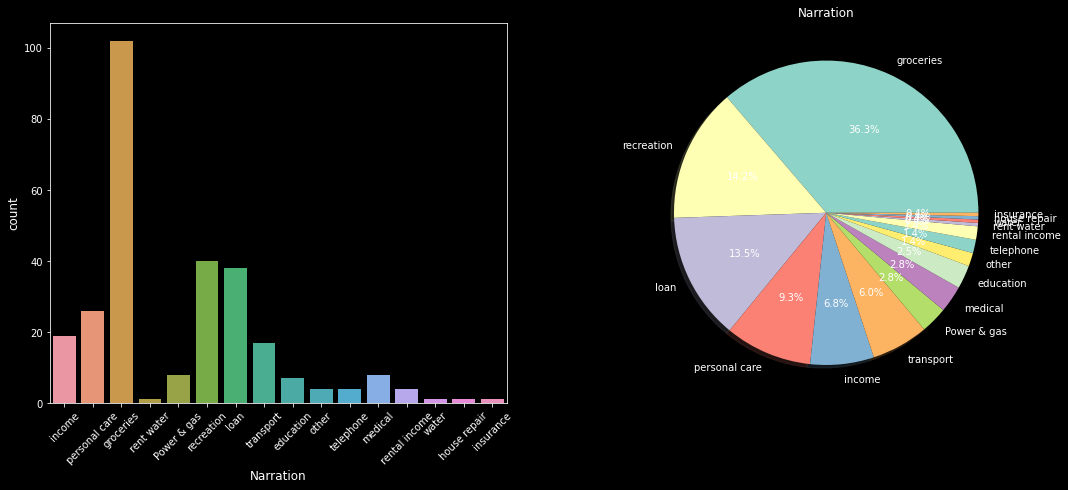

In [15]:
for col in col_cat:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.countplot(x=df[col], ax=ax[0], hue=df[y_label] if CLASSIFICATION else None).set_xlabel(f"{col}")
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
    ax[1].pie(x=df[col].value_counts(), autopct="%.1f%%", shadow=True, labels=df[col].value_counts().index)
    ax[1].set_title(col)
plt.show()

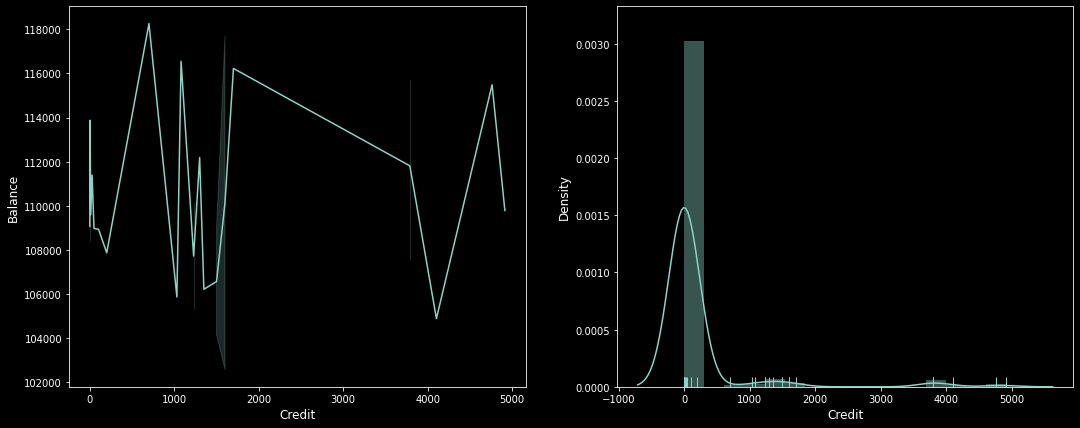

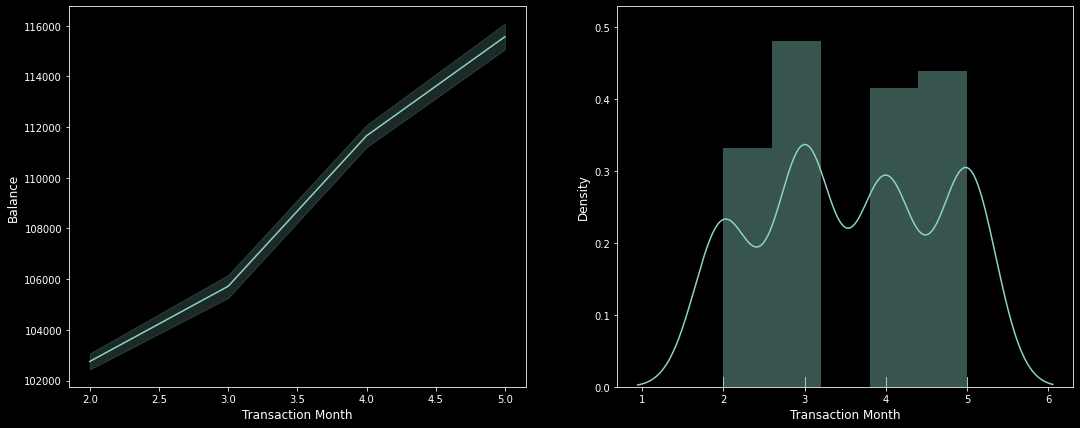

In [16]:
for col in col_num_disc + ([y_label] if CLASSIFICATION else []):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.lineplot(x=df[col], y=df[y_label], ax=ax[0]).set_xlabel(f"{col}")
    sns.distplot(x=df[col], ax=ax[1], rug=True).set_xlabel(f"{col}")
plt.show()

Target looks like regression


[array([[<AxesSubplot:title={'center':'F=2.20E+00'}, xlabel='Debit', ylabel='Balance'>,
         <AxesSubplot:title={'center':'F=1.48E+00'}, xlabel='Credit'>]],
       dtype=object),
 array([[<AxesSubplot:title={'center':'F=1.13E+00'}, xlabel='Balance', ylabel='Narration'>,
         <AxesSubplot:title={'center':'F=1.50E-02'}, xlabel='Balance', ylabel='Transaction Month'>]],
       dtype=object)]

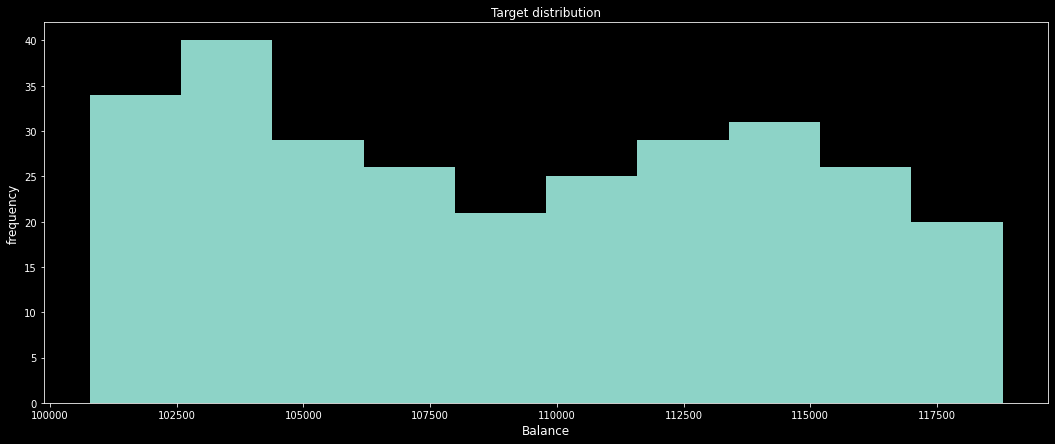

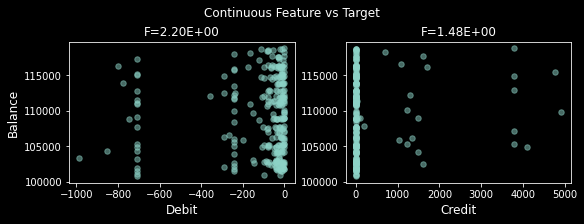

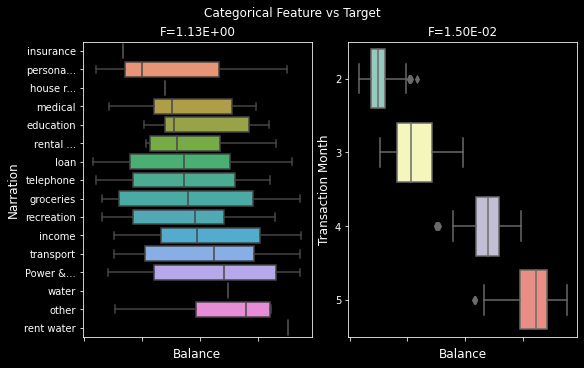

In [17]:
plot(df.drop(y_label, axis=1), df[y_label])

In [18]:
display(df.describe().T.style.background_gradient(cmap="Blues").format("{:.2f}"))
display(df.quantile([0.01, 0.99]).T.style.background_gradient(cmap="Blues").format("{:.2f}"))

,count,mean,std,min,25%,50%,75%,max
Debit,281.00,-120.22,261.45,-3000.00,-83.86,-32.53,-12.00,0.00
Credit,281.00,174.12,728.71,0.00,0.00,0.00,0.00,4913.05
Balance,281.00,109198.92,5294.21,100780.67,104277.60,108933.57,113844.62,118797.03
Transaction Month,281.00,3.58,1.08,2.00,3.00,4.00,5.00,5.00


,0.010000,0.990000
Debit,-811.52,0.00
Credit,0.00,3851.01
Balance,101076.62,118657.22
Transaction Month,2.00,5.00


In [19]:
df_monthly = df.groupby("Narration").sum()[["Debit", "Credit"]] / 4
df_monthly

,Debit,Credit
Narration,,
Power & gas,-106.29,0.00
education,-53.61,0.00
groceries,-1764.67,0.00
house repair,-6.84,0.00
income,0.00,11074.44
insurance,-246.47,0.00
loan,-4819.89,0.00
medical,-313.27,0.00
other,-23.98,0.00


In [20]:
print(f"Total Monthly Income ${df_monthly['Credit'].sum():.2f}")

Total Monthly Income $12232.03


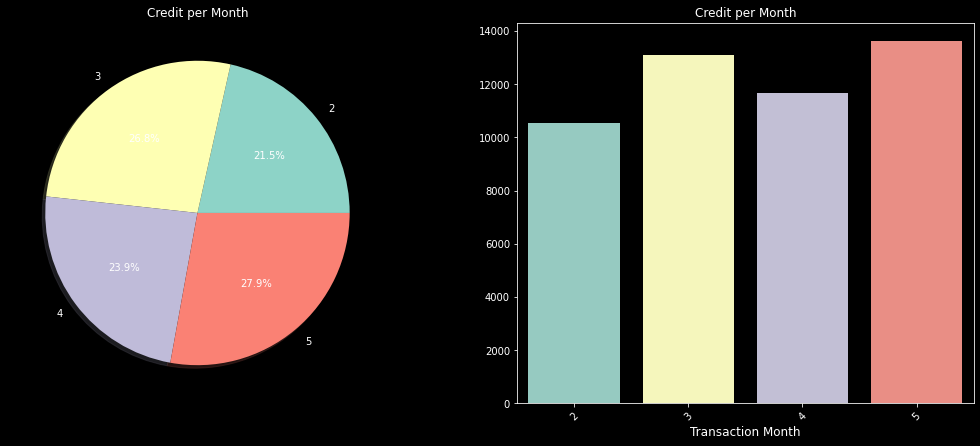

In [21]:
df_monthly_credit_per_month = df.groupby("Transaction Month").sum()[["Credit"]].T.abs()
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].pie(x=df_monthly_credit_per_month.values[0], autopct="%.1f%%", shadow=True, labels=df_monthly_credit_per_month.columns)
ax[0].set_title("Credit per Month")
sns.barplot(x=df_monthly_credit_per_month.columns, y=df_monthly_credit_per_month.values[0], ax=ax[1]).set_title("Credit per Month")
plt.xticks(rotation=45)
plt.show()

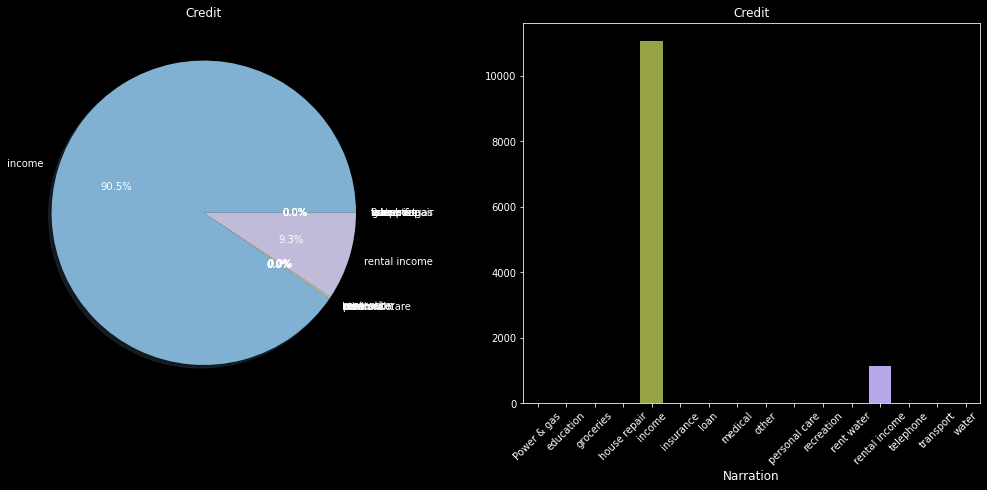

In [22]:
df_monthly_credit = df_monthly[["Credit"]].T.abs()
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].pie(x=df_monthly_credit.values[0], autopct="%.1f%%", shadow=True, labels=df_monthly_credit.columns)
ax[0].set_title("Credit")
sns.barplot(x=df_monthly_credit.columns, y=df_monthly_credit.values[0], ax=ax[1]).set_title("Credit")
plt.xticks(rotation=45)
plt.show()

In [23]:
print(f"Total Monthly Expense ${df_monthly['Debit'].sum():.2f}")
print(f"Total Monthly Loan ${df_monthly.loc['loan', 'Debit']:.2f}")

Total Monthly Expense $-8445.32
Total Monthly Loan $-4819.89


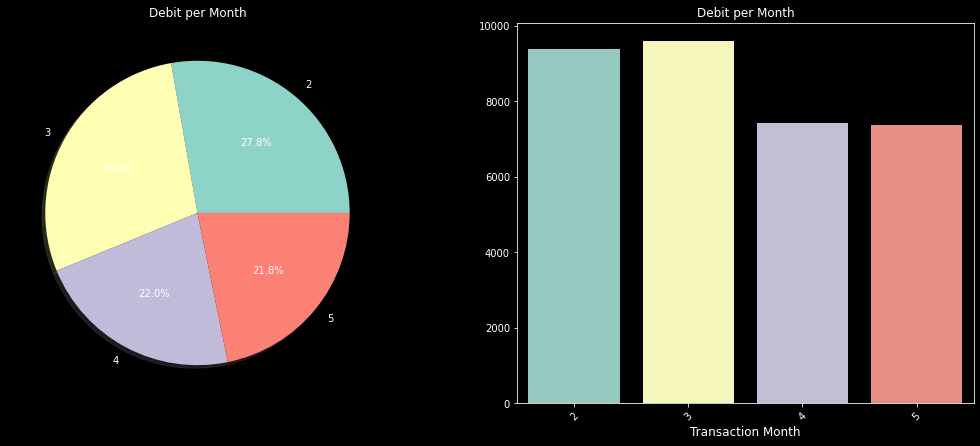

In [24]:
df_monthly_debit_per_month = df.groupby("Transaction Month").sum()[["Debit"]].T.abs()
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].pie(x=df_monthly_debit_per_month.values[0], autopct="%.1f%%", shadow=True, labels=df_monthly_debit_per_month.columns)
ax[0].set_title("Debit per Month")
sns.barplot(x=df_monthly_debit_per_month.columns, y=df_monthly_debit_per_month.values[0], ax=ax[1]).set_title("Debit per Month")
plt.xticks(rotation=45)
plt.show()

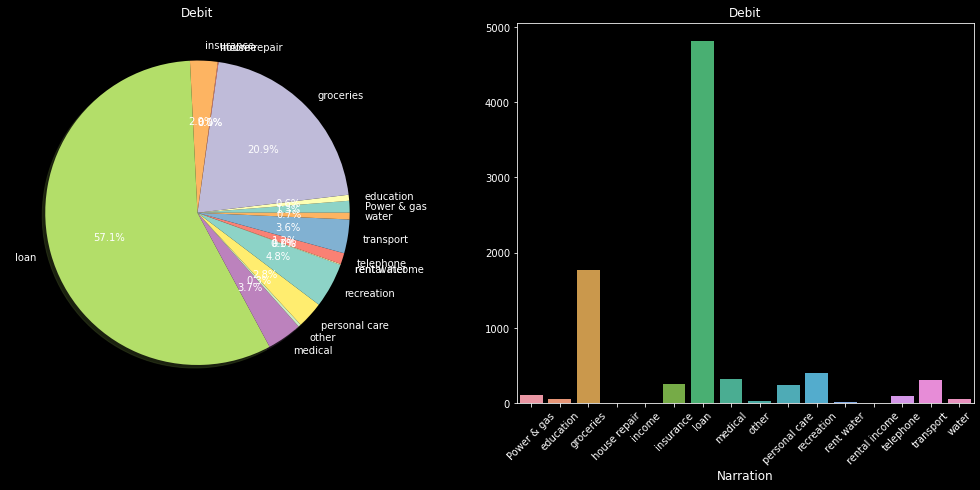

In [25]:
df_monthly_debit = df_monthly[["Debit"]].T.abs()
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].pie(x=df_monthly_debit.values[0], autopct="%.1f%%", shadow=True, labels=df_monthly_debit.columns)
ax[0].set_title("Debit")
sns.barplot(x=df_monthly_debit.columns, y=df_monthly_debit.values[0], ax=ax[1]).set_title("Debit")
plt.xticks(rotation=45)
plt.show()

In [26]:
print(f"Total Monthly Expense without Loan ${df_monthly['Debit'].sum() - df_monthly.loc['loan', 'Debit']:.2f}")

Total Monthly Expense without Loan $-3625.42


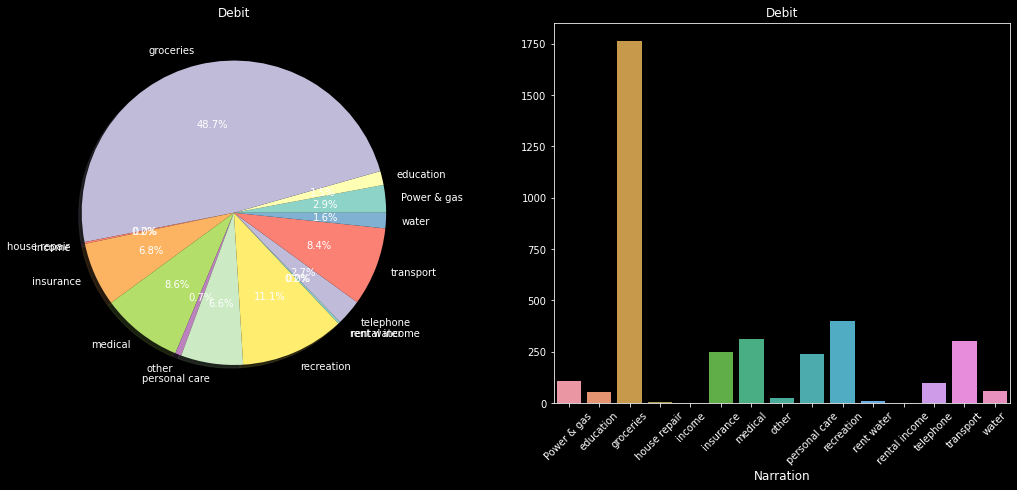

In [27]:
df_monthly_debit_without_loan = df_monthly[["Debit"]].T.abs().drop("loan", axis=1)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].pie(x=df_monthly_debit_without_loan.values[0], autopct="%.1f%%", shadow=True, labels=df_monthly_debit_without_loan.columns)
ax[0].set_title("Debit")
sns.barplot(x=df_monthly_debit_without_loan.columns, y=df_monthly_debit_without_loan.values[0], ax=ax[1]).set_title("Debit")
plt.xticks(rotation=45)
plt.show()

In [28]:
print(f"Total Monthly Saving ${df_monthly.sum().sum():.2f}")

Total Monthly Saving $3786.71


Text(0.5, 1.0, 'Monthly Saving')

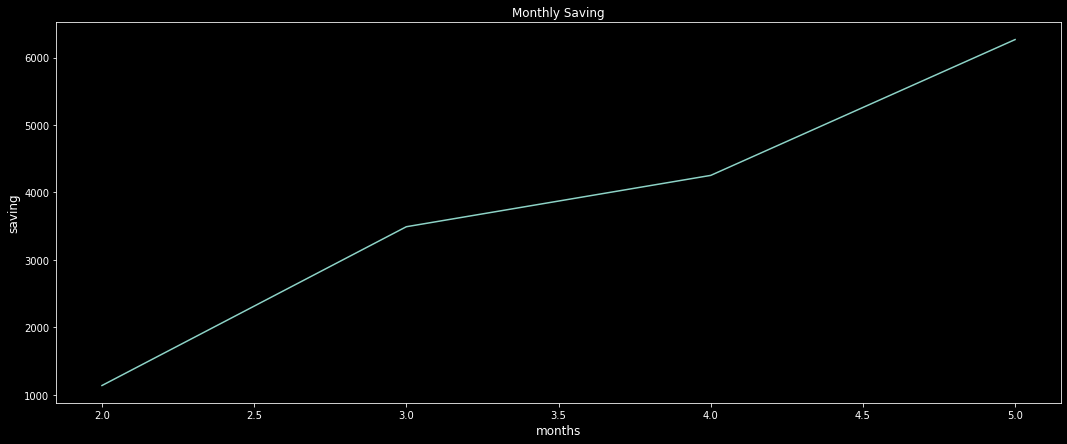

In [29]:
df_monthly_saving = pd.DataFrame(
    {
        "saving": df_monthly_credit_per_month.values[0] - df_monthly_debit_per_month.values[0],
        "months": df_monthly_credit_per_month.columns
    }
)
sns.lineplot(x=df_monthly_saving["months"], y=df_monthly_saving["saving"]).set_title(f"Monthly Saving")